In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
captureSize = 35.8 #for tmb claculation
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)


In [2]:
itrp_data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/SKCM_v2/'
tcga_data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/TCGA/GDC_v37/'
immu_data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/InnateDB/'
nano_data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/NanoString/'
ppi_data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/PPI/'

merge_data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/'
! mkdir -p /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/

In [3]:
! ls -lh /n/data1/hms/dbmi/zitnik/lab/users/was966/TCGA/GDC_v37/*.TABLE

-rw-rw-r-- 1 was966 zitnik 3.4M Sep  1 14:32 /n/data1/hms/dbmi/zitnik/lab/users/was966/TCGA/GDC_v37/GENE.TABLE
-rw-rw-r-- 1 was966 zitnik 1.7M Sep  1 13:33 /n/data1/hms/dbmi/zitnik/lab/users/was966/TCGA/GDC_v37/PATIENTS.TABLE
-rw-rw-r-- 1 was966 zitnik 4.4G Sep  1 14:35 /n/data1/hms/dbmi/zitnik/lab/users/was966/TCGA/GDC_v37/TPM.TABLE


In [4]:
! ls -lh /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/SKCM_v2/*.TABLE

-rw-rw-r-- 1 was966 zitnik 55K Sep  1 14:56 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/SKCM_v2/PATIENTS.TABLE
-rw-rw-r-- 1 was966 zitnik 51M Sep  1 14:56 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/SKCM_v2/TPM_CORRECTION.TABLE
-rw-rw-r-- 1 was966 zitnik 51M Sep  1 14:56 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/SKCM_v2/TPM.TABLE


In [5]:

## ITRP dataset
itrp_patient = pd.read_pickle(os.path.join(itrp_data_path, 'PATIENTS.TABLE'))
itrp_tpm = pd.read_pickle(os.path.join(itrp_data_path, 'TPM.TABLE'))
itrp_tpm_correct = pd.read_pickle(os.path.join(itrp_data_path, 'TPM_CORRECTION.TABLE'))

## TCGA dataset
tcga_gene = pd.read_pickle(os.path.join(tcga_data_path, 'GENE.TABLE'))
tcga_patient = pd.read_pickle(os.path.join(tcga_data_path, 'PATIENTS.TABLE'))
tcga_tpm = pd.read_pickle(os.path.join(tcga_data_path, 'TPM.TABLE'))

## Merge
ensid_freeman = pd.Series(dict(zip(itrp_tpm.index.map(lambda x:x.split('.')[0]), itrp_tpm.index)))
ensid_freeman.name = 'ensid_freeman'
common_genes = set(tcga_tpm.columns.map(lambda x:x.split('.')[0])) & set(itrp_tpm.index.map(lambda x:x.split('.')[0]))
common_genes = list(common_genes)
print(len(common_genes))

tcga_gene = tcga_gene.loc[common_genes]
tcga_gene = tcga_gene[tcga_gene.gene_type == 'protein_coding']
tcga_gene = tcga_gene.join(ensid_freeman)

tcga_tpm = tcga_tpm[tcga_gene.ensid_v36]
tcga_tpm.columns = tcga_gene.gene_name.tolist()

itrp_tpm = itrp_tpm.T[tcga_gene.ensid_freeman]
itrp_tpm.columns = tcga_gene.gene_name.tolist()

itrp_tpm_correct = itrp_tpm_correct.T[tcga_gene.ensid_freeman]
itrp_tpm_correct.columns = tcga_gene.gene_name.tolist()

itrp_patient = itrp_patient.loc[itrp_tpm.index]

18980


In [7]:
tcga_tpm.shape, itrp_tpm.shape, itrp_tpm_correct.shape, tcga_gene.shape

((10184, 18474), (334, 18474), (334, 18474), (18474, 5))

In [8]:
itrp_patient.shape, tcga_patient.shape

((334, 20), (10184, 22))

In [9]:
### remove genes with very low variance
def _sel_genes(x):
    var = x.var(axis=0) 
    sel_genes = var[var > 1e-8].index
    return sel_genes
sgs1 = itrp_tpm.join(itrp_patient.cohort).groupby('cohort').apply(_sel_genes)
var_gene_list = list(set.intersection(*map(set, sgs1)))
len(var_gene_list)

17851

In [10]:
tcga_tpm

,RBFOX1,IL20,MAEA,MYOF,TAF6,OR8B8,FAP,HPS1,TANGO6,VTN,...,ERBB3,ZNF646,MZF1,PRR23B,ZFP30,ZNF720,SEPHS2,KCNA10,GABPA,ASB7
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5KT,0.5340,0.0000,22.6742,17.3924,14.5850,0.0,1.1523,45.4158,6.6230,2145.9226,...,0.0994,8.1506,10.6149,0.0,1.0746,2.0960,100.3533,0.0,11.4706,4.0424
TCGA-OR-A5J9,0.4415,0.0000,60.9314,3.2201,23.3330,0.0,0.5689,51.5042,5.4434,12.9794,...,0.0583,12.0141,29.3325,0.0,8.1186,4.9041,203.9659,0.0,23.4111,10.1465
TCGA-OR-A5K0,1.4946,0.0000,33.0752,8.0893,25.5266,0.0,0.1308,51.4318,3.1633,383.7630,...,0.1219,11.9541,0.0623,0.0,0.9354,5.3254,123.8969,0.0,18.4675,8.3806
TCGA-OR-A5L6,0.0504,0.0000,9.2956,6.6972,3.4462,0.0,0.9399,17.6709,2.3824,161.3534,...,0.2695,3.9186,15.3155,0.0,1.9833,1.5062,51.8703,0.0,6.6188,3.1416
TCGA-OR-A5LT,0.0225,0.0000,32.4763,15.1470,5.4882,0.0,2.7409,21.2035,2.9260,13.8575,...,0.1121,4.6611,42.3630,0.0,3.4060,1.7223,65.9448,0.0,33.1260,3.7104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-V4-A9EX,0.0142,0.0000,53.0674,20.8053,19.8222,0.0,0.2331,88.2903,15.7547,8.8830,...,56.2069,13.4708,11.7664,0.0,3.5543,3.4803,390.8061,0.0,14.8545,12.2857
TCGA-WC-A883,0.0365,0.0000,19.6645,5.2446,11.4031,0.0,0.7687,47.8180,5.0290,12.1828,...,21.9787,7.1228,8.9271,0.0,1.2849,0.9404,111.2767,0.0,7.5547,5.6894
TCGA-V4-A9F7,0.0214,0.3578,24.6981,1.8162,24.6516,0.0,13.8083,155.6554,4.7360,0.3534,...,160.8949,11.4608,9.1428,0.0,2.4961,3.0503,102.9203,0.0,16.7664,12.3212


In [11]:
var = tcga_tpm.var() 
var_gene_list = var[var > 1e-4].index
len(var_gene_list)

18425

In [12]:
var_gene_list

Index(['RBFOX1', 'IL20', 'MAEA', 'MYOF', 'TAF6', 'OR8B8', 'FAP', 'HPS1',
       'TANGO6', 'VTN',
       ...
       'ERBB3', 'ZNF646', 'MZF1', 'PRR23B', 'ZFP30', 'ZNF720', 'SEPHS2',
       'KCNA10', 'GABPA', 'ASB7'],
      dtype='object', length=18425)

### select Immunogenes

In [13]:
# Immunogenes
df_immu_gene = pd.read_pickle(os.path.join(immu_data_path, 'InnateDB.TABLE'))
immu_gene_list = list(set(df_immu_gene.gene_name) & set(var_gene_list))

# NanoString genes
df_nano_gene = pd.read_pickle(os.path.join(nano_data_path, 'NanoString.TABLE'))
nano_gene_list = list(set(df_nano_gene.index) & set(var_gene_list))
len(df_immu_gene), len(immu_gene_list), len(df_nano_gene), len(nano_gene_list)

(7394, 6575, 756, 735)

In [15]:
df_nano_gene.shape

(756, 5)

In [16]:
nano_gene_list1 = list(set(df_nano_gene.index) & set(var_gene_list))
nano_gene_list2 = list(set(df_nano_gene.index) & set(tcga_gene.gene_name))

In [17]:
itrp_tpm[list(set(nano_gene_list2) - set(nano_gene_list1))].var().sort_values()

Series([], dtype: float64)

In [18]:
from umap import UMAP

/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distanc

UMAP(angular_rp_forest=True, metric='correlation', verbose=1)
Mon Sep 11 05:30:07 2023 Construct fuzzy simplicial set
Mon Sep 11 05:30:08 2023 Finding Nearest Neighbors
Mon Sep 11 05:30:08 2023 Building RP forest with 12 trees
Mon Sep 11 05:30:16 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	Stopping threshold met -- exiting after 6 iterations
Mon Sep 11 05:30:46 2023 Finished Nearest Neighbor Search
Mon Sep 11 05:30:49 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Mon Sep 11 05:31:01 2023 Finished embedding


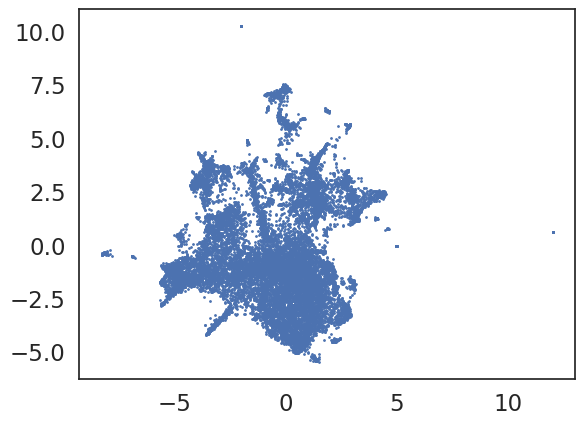

In [19]:
x = np.log2(tcga_tpm[var_gene_list]+1).T
mp = UMAP(metric='correlation',verbose=1)
mp = mp.fit(x)
x2d = mp.transform(x)
plt.scatter(x2d[:,0], x2d[:,1], s = 1)

UMAP(angular_rp_forest=True, metric='correlation', verbose=1)
Wed Sep  6 10:07:01 2023 Construct fuzzy simplicial set
Wed Sep  6 10:07:01 2023 Finding Nearest Neighbors
Wed Sep  6 10:07:01 2023 Building RP forest with 9 trees
Wed Sep  6 10:07:03 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Wed Sep  6 10:07:14 2023 Finished Nearest Neighbor Search
Wed Sep  6 10:07:14 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  6 10:07:31 2023 Finished embedding


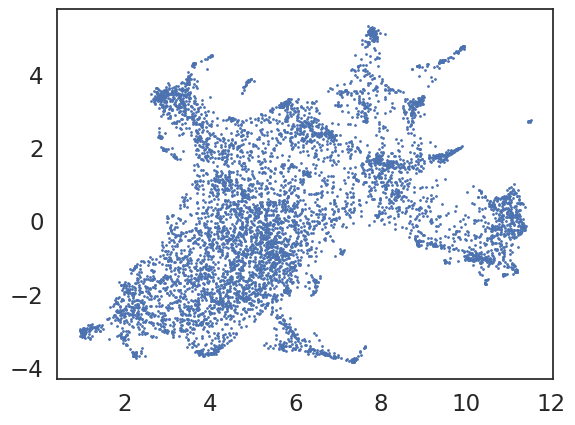

In [16]:
x = np.log2(tcga_tpm[immu_gene_list]+1).T
mp = UMAP(metric='correlation',verbose=1)
mp = mp.fit(x)
x2d = mp.transform(x)
plt.scatter(x2d[:,0], x2d[:,1], s = 1)

In [17]:
len(set(nano_gene_list) - set(immu_gene_list))

65

In [20]:
x

bcr_patient_barcode,TCGA-OR-A5KT,TCGA-OR-A5J9,TCGA-OR-A5K0,TCGA-OR-A5L6,TCGA-OR-A5LT,TCGA-OR-A5JZ,TCGA-OR-A5JK,TCGA-OR-A5JT,TCGA-OR-A5JV,TCGA-OR-A5LE,...,TCGA-VD-AA8Q,TCGA-VD-AA8P,TCGA-V4-A9EL,TCGA-WC-A87W,TCGA-V4-A9EF,TCGA-V4-A9EX,TCGA-WC-A883,TCGA-V4-A9F7,TCGA-V4-A9F5,TCGA-V4-A9E8
MAP4K2,3.674246,3.044919,4.123327,1.704208,2.272202,2.101885,2.049805,2.281253,2.687038,3.812447,...,2.579639,2.665552,3.287029,2.724803,2.759774,3.398515,2.626135,3.459943,2.612777,3.826030
IL7,0.670659,0.556307,0.227741,0.434134,1.157302,1.770575,0.547055,1.596554,1.717693,0.000000,...,0.043764,0.000000,1.114167,0.463309,0.092884,0.280481,0.342441,0.532367,0.292075,0.039279
ERCC3,3.981359,4.086835,4.569831,3.171479,3.433600,3.679154,2.483571,4.071068,3.597138,4.800377,...,2.120850,4.113142,4.542518,5.324483,4.050092,4.728220,4.058152,4.413445,3.572259,3.587605
TNFAIP3,4.274277,6.665923,3.661738,2.762561,1.915750,4.253233,2.959770,4.406224,4.922022,6.091844,...,0.897937,1.455912,2.965249,3.446217,1.342953,1.645563,2.149227,2.515990,0.505383,1.133564
RUNX1,2.807623,0.842697,0.758303,1.165044,1.169284,1.780730,1.411969,1.332565,1.985719,0.874443,...,0.323889,1.061016,2.062364,1.107554,0.983459,1.309176,1.022758,0.785425,0.845671,1.239031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TLR5,0.980683,1.249870,0.214995,0.621899,0.587941,1.348346,1.681809,0.724738,2.118493,0.055612,...,0.785174,0.737514,0.817541,1.402067,0.377179,0.639417,0.561888,1.144634,0.277390,0.558562
PSMB10,4.561124,3.840997,3.703112,4.670835,3.771822,6.014346,5.028445,5.703328,4.708844,3.126263,...,3.459222,4.024736,6.543637,4.005005,4.758511,5.138986,4.153424,4.266172,5.605370,5.939356
TRIM39,2.644895,3.146965,3.414744,2.510000,2.360196,2.793979,2.345084,3.096616,2.486946,2.565134,...,2.269691,2.628120,3.598996,4.302282,3.106985,3.818288,2.990737,4.139527,2.866136,3.427713
TNFRSF13B,0.885340,0.000000,0.000000,0.000000,0.000000,0.000000,0.265677,0.000000,0.083928,0.000000,...,0.000000,0.000000,0.072174,0.000000,0.000000,0.022616,0.019346,0.000000,0.000000,0.144699


UMAP(angular_rp_forest=True, metric='correlation', n_neighbors=5, verbose=1)
Mon Sep 11 05:31:06 2023 Construct fuzzy simplicial set
Mon Sep 11 05:31:14 2023 Finding Nearest Neighbors
Mon Sep 11 05:31:17 2023 Finished Nearest Neighbor Search
Mon Sep 11 05:31:17 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Sep 11 05:31:19 2023 Finished embedding


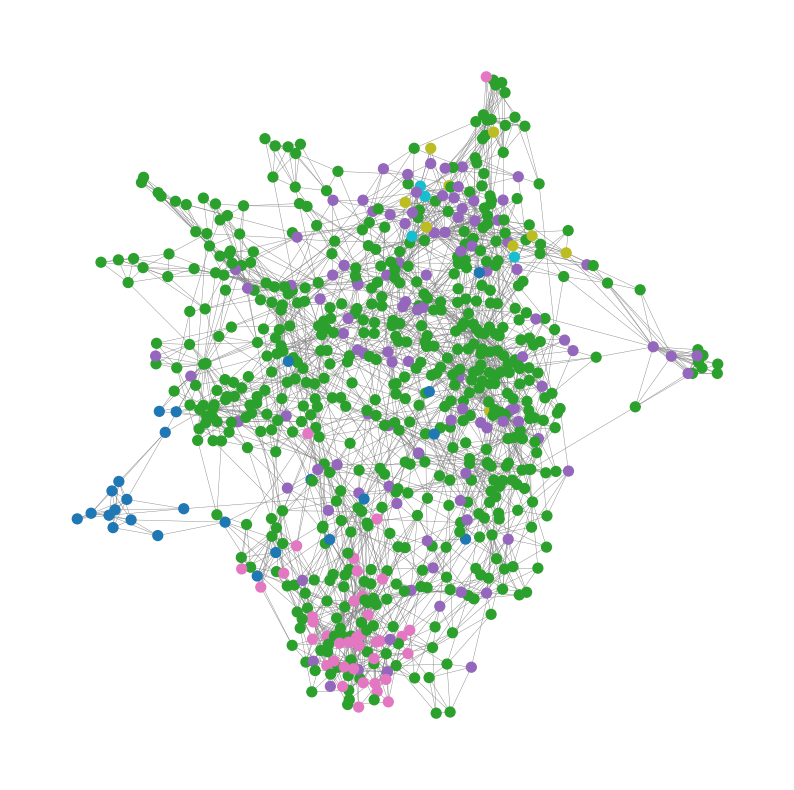

In [20]:
x = np.log2(tcga_tpm[nano_gene_list]+1).T
mp = UMAP(n_neighbors=5,  metric='correlation', local_connectivity=1.0, verbose=1)
mp = mp.fit(x)
x2d = mp.transform(x)

coo_graph = mp.graph_.tocoo()
edge_df = pd.DataFrame(
    np.vstack([coo_graph.row, coo_graph.col, coo_graph.data]).T,
    columns=("source", "target", "weight"),
)
edge_df["source"] = edge_df.source.astype(np.int32)
edge_df["target"] = edge_df.target.astype(np.int32)

import networkx as nx
fig, ax = plt.subplots(figsize = (10, 10))
A = mp.graph_.toarray()

G = nx.from_numpy_array(np.matrix(A))
layout = nx.layout.spring_layout(G,seed=123)

dfs = pd.DataFrame(mp.embedding_, columns = ['x','y'], index=nano_gene_list)
s = df_nano_gene.gene_class.unique()
c = df_nano_gene.gene_class.map(dict(zip(s, range(len(s))))).to_frame(name = 'c')

dfs = dfs.join(c)

nx.draw(G, layout, ax = ax, node_size = 50, edge_color = 'gray', 
        width = 0.3, node_color= dfs.c, cmap='tab10')
plt.show()

UMAP(angular_rp_forest=True, local_connectivity=0.5, metric='correlation', n_neighbors=5, verbose=1)
Mon Sep 11 05:31:24 2023 Construct fuzzy simplicial set
Mon Sep 11 05:31:32 2023 Finding Nearest Neighbors
Mon Sep 11 05:31:32 2023 Finished Nearest Neighbor Search
Mon Sep 11 05:31:32 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Sep 11 05:31:35 2023 Finished embedding


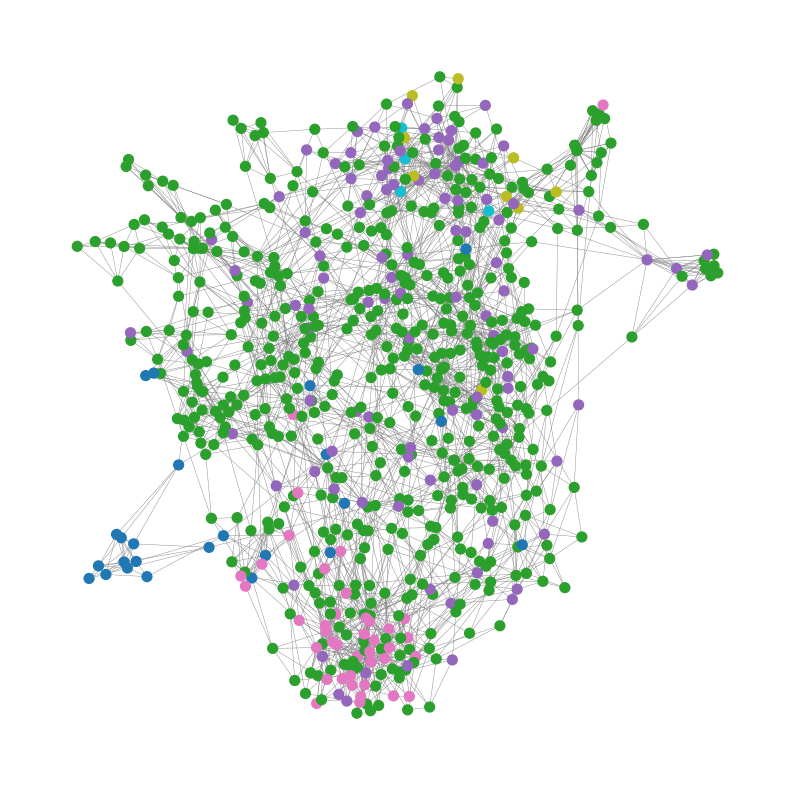

In [21]:
x = np.log(tcga_tpm[nano_gene_list]+1).T
mp = UMAP(n_neighbors=5,  metric='correlation', local_connectivity=0.5, verbose=1)
mp = mp.fit(x)
x2d = mp.transform(x)

coo_graph = mp.graph_.tocoo()
edge_df2 = pd.DataFrame(
    np.vstack([coo_graph.row, coo_graph.col, coo_graph.data]).T,
    columns=("source", "target", "weight"),
)
edge_df2["source"] = edge_df.source.astype(np.int32)
edge_df2["target"] = edge_df.target.astype(np.int32)

import networkx as nx
fig, ax = plt.subplots(figsize = (10, 10))
A = mp.graph_.toarray()

G = nx.from_numpy_array(np.matrix(A))
layout = nx.layout.spring_layout(G,seed=123)

dfs = pd.DataFrame(mp.embedding_, columns = ['x','y'], index=nano_gene_list)
s = df_nano_gene.gene_class.unique()
c = df_nano_gene.gene_class.map(dict(zip(s, range(len(s))))).to_frame(name = 'c')

dfs = dfs.join(c)

nx.draw(G, layout, ax = ax, node_size = 50, edge_color = 'gray', 
        width = 0.3, node_color= dfs.c, cmap='tab10')
plt.show()

<Axes: >

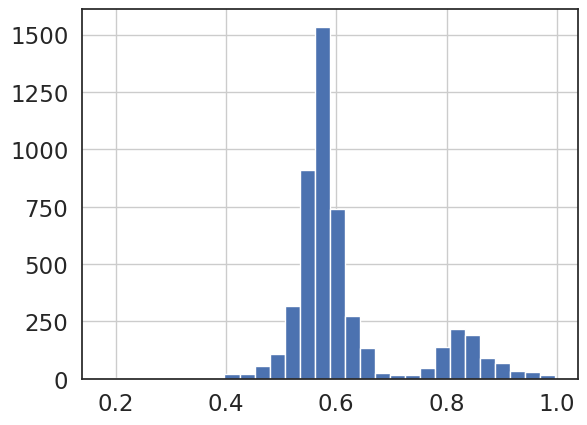

In [104]:
edge_df2.weight.hist(bins=30)

<Axes: >

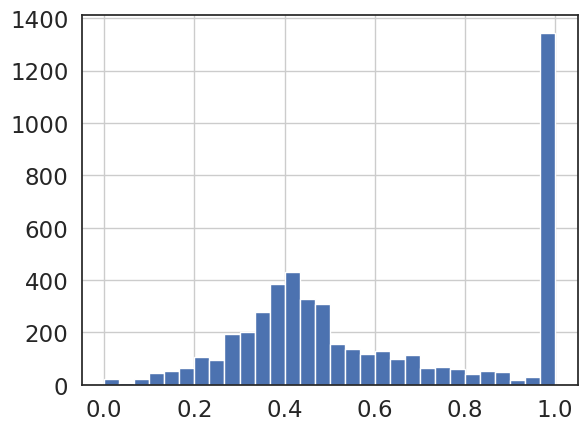

In [103]:
edge_df.weight.hist(bins=30)

In [106]:
edge_df[edge_df.weight==1]

,source,target,weight
1,0,149,1.0
4,0,422,1.0
7,1,77,1.0
15,2,481,1.0
19,3,617,1.0
...,...,...,...
5000,732,331,1.0
5003,732,547,1.0
5006,733,267,1.0
5012,734,55,1.0


In [115]:
edge_df[edge_df.source==0]

,source,target,weight
0,0,23,0.621931
1,0,149,1.000000
2,0,372,0.430467
3,0,391,0.524109
4,0,422,1.000000
5,0,557,0.308082
6,0,575,0.391925


In [117]:
x.iloc[[0, 149]].T.corr()

,CX3CR1,CYFIP2
CX3CR1,1.000000,0.515554
CYFIP2,0.515554,1.000000


In [118]:
x.iloc[[0, 23]].T.corr()

,CX3CR1,LILRA1
CX3CR1,1.000000,0.690386
LILRA1,0.690386,1.000000


In [120]:
x.iloc[[0, 575]].T.corr()

,CX3CR1,CSF1R
CX3CR1,1.000000,0.660623
CSF1R,0.660623,1.000000


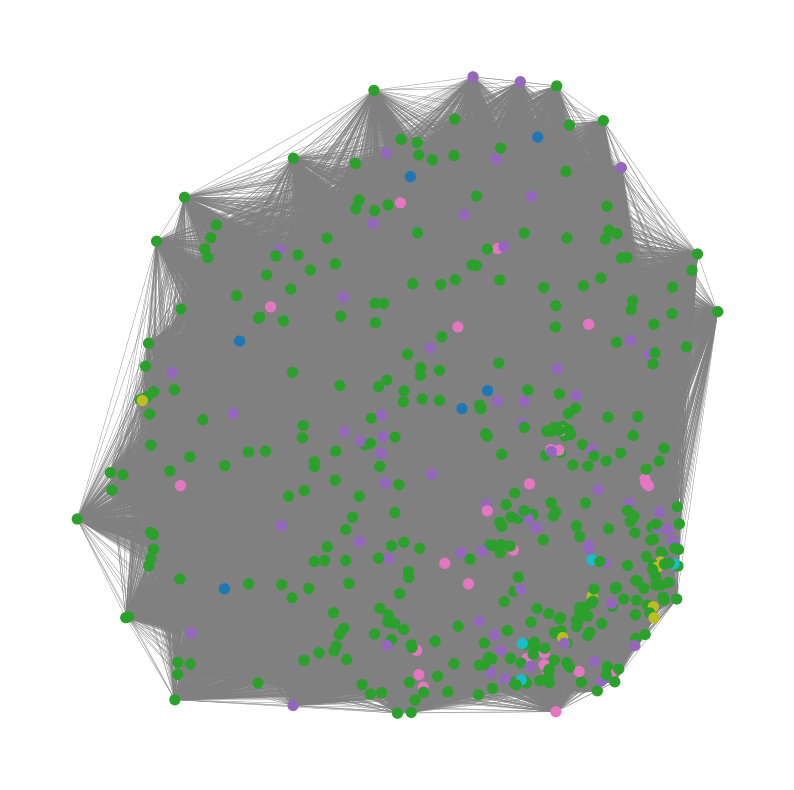

In [192]:
corr = x.T.corr()
d = 1.-corr

mask = (corr > 0.6).sum()
ss = mask.sort_values() 
sidx = ss[ss > 1].index

d = d.loc[sidx][sidx]
m = mask.loc[sidx][sidx]

A1 = (d*m).values
np.fill_diagonal(A1,0)

import networkx as nx
fig, ax = plt.subplots(figsize = (10, 10))
#A = mp.graph_.toarray()

G = nx.from_numpy_array(np.matrix(A1))
layout = nx.layout.spring_layout(G)

dfs = pd.DataFrame(mp.embedding_, columns = ['x','y'], index=nano_gene_list)
s = df_nano_gene.gene_class.unique()
c = df_nano_gene.gene_class.map(dict(zip(s, range(len(s))))).to_frame(name = 'c')

dfs = pd.DataFrame(index=sidx).join(c)

nx.draw(G, layout, ax = ax, node_size = 50, edge_color = 'gray', 
        width = 0.3, node_color= dfs.c, cmap='tab10')
#plt.show()

In [186]:
ss

PMCH        1
IFNA7       6
IFNA17      6
CTAGE1      9
FUT5       11
         ... 
HCK       598
IRF2      601
CSF2RB    602
STAT1     602
NFKB1     614
Length: 735, dtype: int64

ValueError: 'c' argument has 735 elements, which is inconsistent with 'x' and 'y' with size 734.

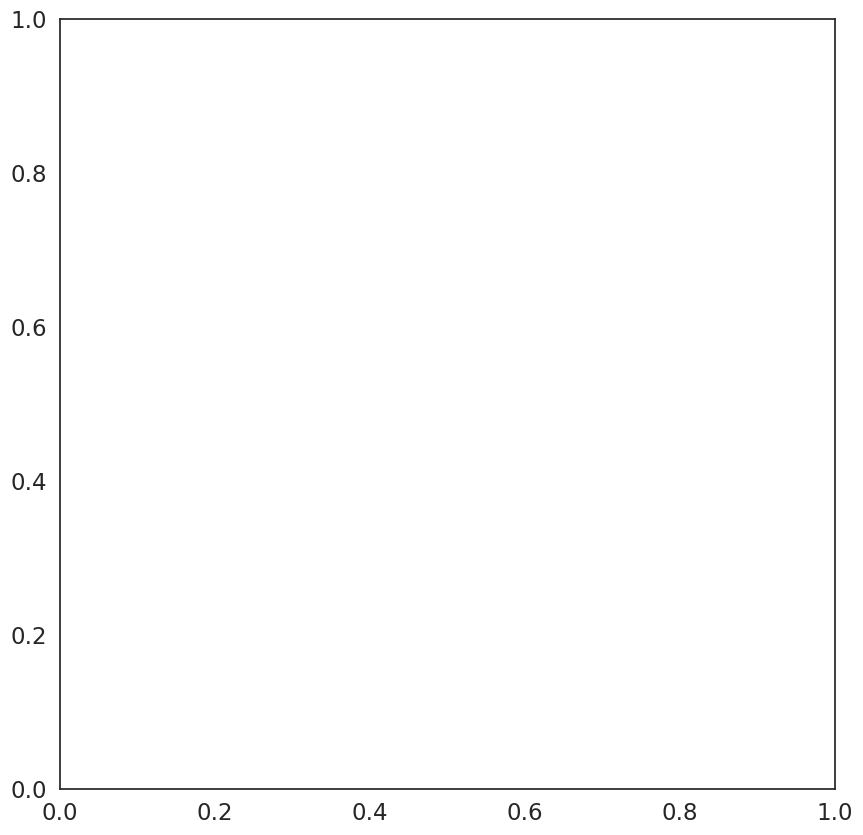

In [188]:
dfs

,degree,c
PMCH,1,2
IFNA7,6,1
IFNA17,6,1
CTAGE1,9,0
FUT5,11,2
...,...,...
HCK,598,1
IRF2,601,1
CSF2RB,602,1
STAT1,602,1


In [142]:
A1

array([[ 0.        ,  0.        ,  0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.48038756,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.36566457,
         0.        ,  0.63699233],
       ...,
       [-0.        ,  0.48038756,  0.36566457, ...,  0.        ,
         0.        ,  0.63093439],
       [-0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.        ],
       [-0.        ,  0.        ,  0.63699233, ...,  0.63093439,
        -0.        ,  0.        ]])

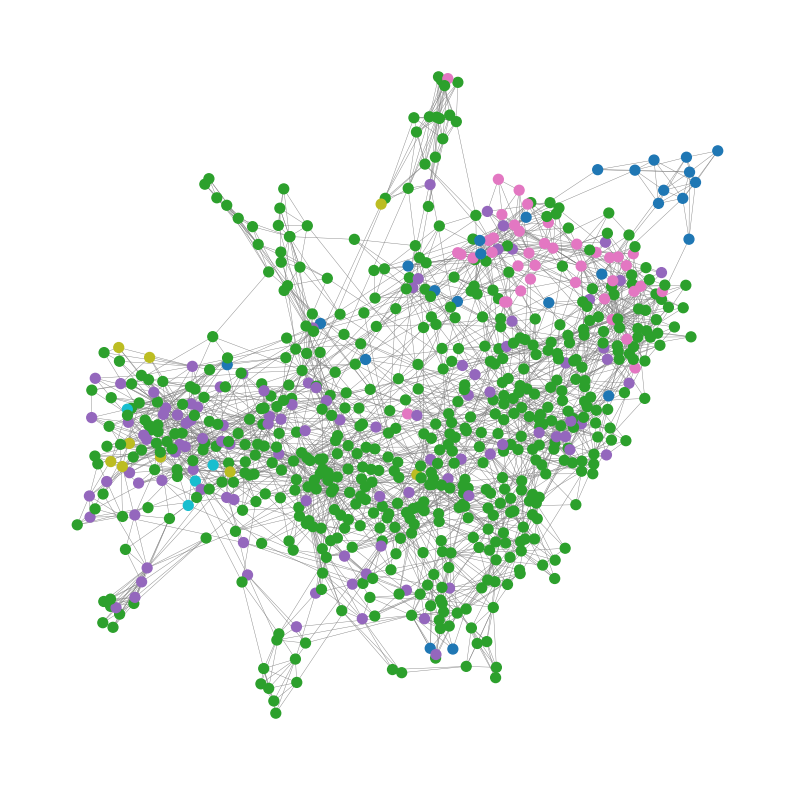

In [20]:
import networkx as nx
fig, ax = plt.subplots(figsize = (10, 10))
A = mp.graph_.toarray()

G = nx.from_numpy_array(np.matrix(A))
layout = nx.layout.spring_layout(G,seed=123)

dfs = pd.DataFrame(mp.embedding_, columns = ['x','y'], index=nano_gene_list)
s = df_nano_gene.gene_class.unique()
c = df_nano_gene.gene_class.map(dict(zip(s, range(len(s))))).to_frame(name = 'c')

dfs = dfs.join(c)

nx.draw(G, layout, ax = ax, node_size = 50, edge_color = 'gray', 
        width = 0.3, node_color= dfs.c, cmap='tab10')
plt.show()

In [24]:
from scipy.spatial.distance import cdist, squareform
from scipy.stats import entropy, truncnorm

def get_graph_v(embd):
    '''
    Get the graph in low dimension
    '''
    distances = cdist(embd.embedding_, embd.embedding_)
    a = embd._a
    b = embd._b
    graph_v = 1.0 / (1.0 + a * distances ** (2 * b))        
    return graph_v

fig, ax = plt.subplots(figsize = (10, 10))
gv = get_graph_v(mp)
np.fill_diagonal(gv,0)
A1 = gv*(np.bool_(A))

G = nx.from_numpy_array(np.matrix(A1))
layout = nx.layout.spring_layout(G,iterations=50)

dfs = pd.DataFrame(mp.embedding_, columns = ['x','y'], index=nano_gene_list)
s = df_nano_gene.gene_class.unique()
c = df_nano_gene.gene_class.map(dict(zip(s, range(len(s))))).to_frame(name = 'c')

dfs = dfs.join(c)

nx.draw(G, layout, ax = ax, node_size = 50, edge_color = 'gray', 
        width = 0.3, node_color= dfs.c, cmap='tab10')
plt.show()

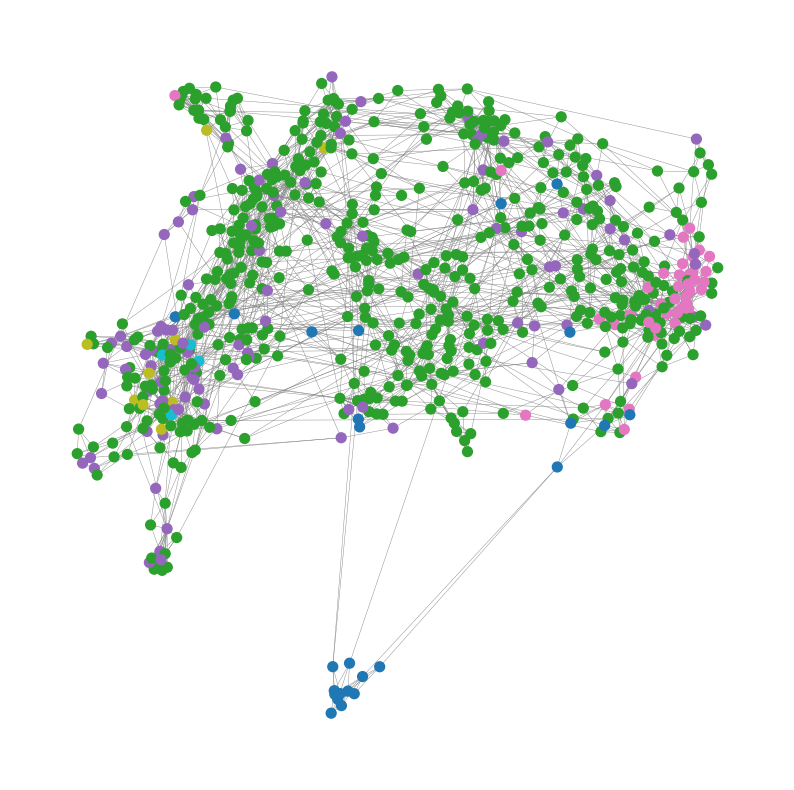

In [133]:
gv

array([[0.        , 0.04166938, 0.04748991, ..., 0.05834977, 0.01685878,
        0.04309586],
       [0.04166938, 0.        , 0.22919803, ..., 0.1438526 , 0.00873815,
        0.23860245],
       [0.04748991, 0.22919803, 0.        , ..., 0.4903402 , 0.01023158,
        0.83921876],
       ...,
       [0.05834977, 0.1438526 , 0.4903402 , ..., 0.        , 0.01149896,
        0.37425854],
       [0.01685878, 0.00873815, 0.01023158, ..., 0.01149896, 0.        ,
        0.0098716 ],
       [0.04309586, 0.23860245, 0.83921876, ..., 0.37425854, 0.0098716 ,
        0.        ]])

In [36]:
edge_df

,source,target,weight
0,0,23,0.621931
1,0,149,1.000000
2,0,372,0.430467
3,0,391,0.524109
4,0,422,1.000000
...,...,...,...
5015,734,484,1.000000
5016,734,497,0.420692
5017,734,500,0.335258
5018,734,597,0.385837


In [47]:
import numpy as np
import numba
from warnings import warn


import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm

import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd

edge_bundling=None
edge_cmap="gray_r"
show_points=False
labels=None
values=None
theme=None
cmap="Blues"
color_key=None
color_key_cmap="Spectral"
background="white"
width=800
height=800
umap_object = mp

Text(0.99, 0.01, 'UMAP: n_neighbors=5, min_dist=0.1')

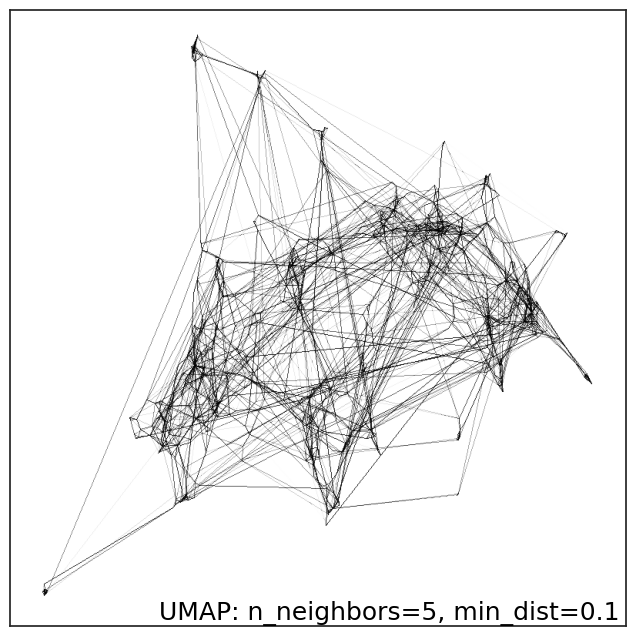

In [62]:
from umap.plot import _get_embedding, _get_extent,_select_font_color,_embed_datashader_in_an_axis

if theme is not None:
    cmap = _themes[theme]["cmap"]
    color_key_cmap = _themes[theme]["color_key_cmap"]
    edge_cmap = _themes[theme]["edge_cmap"]
    background = _themes[theme]["background"]

points = _get_embedding(umap_object)
point_df = pd.DataFrame(points, columns=("x", "y"))

point_size = 100.0 / np.sqrt(points.shape[0])
if point_size > 1:
    px_size = int(np.round(point_size))
else:
    px_size = 1

if show_points:
    edge_how = "log"
else:
    edge_how = "eq_hist"

coo_graph = umap_object.graph_.tocoo()
edge_df = pd.DataFrame(
    np.vstack([coo_graph.row, coo_graph.col, coo_graph.data]).T,
    columns=("source", "target", "weight"),
)
edge_df["source"] = edge_df.source.astype(np.int32)
edge_df["target"] = edge_df.target.astype(np.int32)

extent = _get_extent(points)
canvas = ds.Canvas(
    plot_width=width,
    plot_height=height,
    x_range=(extent[0], extent[1]),
    y_range=(extent[2], extent[3]),
)

if edge_bundling is None:
    edges = bd.directly_connect_edges(point_df, edge_df, weight="weight")
elif edge_bundling == "hammer":
    warn(
        "Hammer edge bundling is expensive for large graphs!\n"
        "This may take a long time to compute!"
    )
    edges = bd.hammer_bundle(point_df, edge_df, weight="weight")
else:
    raise ValueError("{} is not a recognised bundling method".format(edge_bundling))

edge_img = tf.shade(
    canvas.line(edges, "x", "y", agg=ds.sum("weight")),
    cmap=plt.get_cmap(edge_cmap),
    how=edge_how,
)
edge_img = tf.set_background(edge_img, background)

if show_points:
    point_img = _datashade_points(
        points,
        None,
        labels,
        values,
        cmap,
        color_key,
        color_key_cmap,
        None,
        width,
        height,
        False,
    )
    if px_size > 1:
        point_img = tf.dynspread(point_img, threshold=0.5, max_px=px_size)
    result = tf.stack(edge_img, point_img, how="over")
else:
    result = edge_img

font_color = _select_font_color(background)

dpi = plt.rcParams["figure.dpi"]
fig = plt.figure(figsize=(width / dpi, height / dpi))
ax = fig.add_subplot(111)

_embed_datashader_in_an_axis(result, ax)

ax.set(xticks=[], yticks=[])
ax.text(
    0.99,
    0.01,
    "UMAP: n_neighbors={}, min_dist={}".format(
        umap_object.n_neighbors, umap_object.min_dist
    ),
    transform=ax.transAxes,
    horizontalalignment="right",
    color=font_color,
)



In [63]:
A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)